## This notebook contains analysis for eOPN3 slice work

### To use igorpy package, please do the following:
#### Edit line 249 in igorpy.py in the igor package
#### Usually in the path: /opt/anaconda3/lib/python3.8/site-packages/igor/igorpy.py
####         elif isinstance(record, _PackedFileRecord):
####            r = PackedFile(record.text) > comment this out and change it to the following line
####            r = PackedFile("")



In [1]:
import igor.igorpy as igor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pprint
import pandas as pd
import scipy
import pyabf

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def load_igor_pxp(filename):
    exp=igor.load(filename)
    traces=[]
    for i,s in enumerate(exp.data.chan1):
        if "sweep" in str(s):
            traces.append(s.data)
    return traces
def trace_to_df(traces):
    s = np.arange(len(traces[0]))/20000
    # traces
    df = pd.DataFrame(traces).T
    df.index = s
    return df
def load_igor_to_df(filename):
    traces = load_igor_pxp(filename)
    df = trace_to_df(traces)
    return df

In [3]:
def load_abf_to_df(filename):
    abf=pyabf.ABF(filename)
    traces=[]
    for i in abf.sweepList:
        abf.setSweep(i)
        traces.append(abf.sweepY)
    s = abf.sweepX
    df = pd.DataFrame(traces).T
    df.index = s
    return df

def concat_df(df_list):
    result = pd.concat(frames)
    return result

In [4]:
def plot_traces(traces,ax=None,color='C0'):
    if ax==None:
        fig,ax=plt.subplots()

    if type(traces[0])==np.float32:
        s = np.arange(len(traces))/20000
        ax.plot(s,traces,lw=0.8,c=color,alpha=1)
    else:
        s = np.arange(len(traces[0]))/20000
        for t in traces:
            ax.plot(s,t,lw=0.8,c=color,alpha=0.25)
        
    return ax

In [5]:
from scipy.signal import find_peaks
def find_peak_1(df,i,interval=[0.508,0.52]):
    x = df[interval[0]:interval[1]][i]
    if x.min()>0:
        height = -x.min()-x.min()*0.05
    else:
        height = -x.min()*0.99
    peaks, _ = find_peaks(-x,height=-x.min()*0.95) # only 1 peak
    t_peak = x.index[peaks[0]]
    idx_peak = peaks[0]
    value_peak = x.iloc[peaks[0]]
    return t_peak,idx_peak,value_peak
def find_peak_2(df,i,interval=[0.548,0.56]):
    x = df[interval[0]:interval[1]][i]
    if x.min()>0:
        height = -x.min()-x.min()*0.05
    else:
        height = -x.min()*0.99
    peaks, _ = find_peaks(-x,height=-x.min()*0.95) # only 1 peak
    t_peak = x.index[peaks[0]]
    idx_peak = peaks[0]
    value_peak = x.iloc[peaks[0]]
    return t_peak,idx_peak,value_peak

def find_baseline(df,i):
    interval = [0.45,0.5]
    x = df[interval[0]:interval[1]][i]
    return x.mean()

## use a different find peak function for abf files since the intervals are different

def find_peak_1_abf(df,i,interval=[1.2525,1.29]):
    x = df[interval[0]:interval[1]][i]
    if x.min()>0:
        height = -x.min()-x.min()*0.05
    else:
        height = -x.min()*0.99
    peaks, _ = find_peaks(-x,height=height) # only 1 peak
    t_peak = x.index[peaks[0]]
    idx_peak = peaks[0]
    value_peak = x.iloc[peaks[0]]
    return t_peak,idx_peak,value_peak
def find_peak_2_abf(df,i,interval=[1.29275,1.31]):
    x = df[interval[0]:interval[1]][i]
    if x.min()>0:
        height = -x.min()-x.min()*0.05
    else:
        height = -x.min()*0.99
    x = df[interval[0]:interval[1]][i]
    peaks, _ = find_peaks(-x,height=height) # only 1 peak
    t_peak = x.index[peaks[0]]
    idx_peak = peaks[0]
    value_peak = x.iloc[peaks[0]]
    return t_peak,idx_peak,value_peak

def find_baseline_abf(df,i):
    interval = [1.199,1.249]
    x = df[interval[0]:interval[1]][i]
    return x.mean()

def find_amp(baseline,value_peak):
    return abs(baseline-value_peak)
def amps_2_pulse(df,i):
    baseline = find_baseline(df,i)
    t_peak,idx_peak,value_peak = find_peak_1(df,i)
    amp_1 = find_amp(baseline,value_peak)
    t_peak,idx_peak,value_peak = find_peak_2(df,i)
    amp_2 = find_amp(baseline,value_peak)
    PPR = amp_2/amp_1
    return amp_1,amp_2,PPR

def amps_2_pulse_abf(df,i):
    baseline = find_baseline_abf(df,i)
    t_peak,idx_peak,value_peak = find_peak_1_abf(df,i)
    amp_1 = find_amp(baseline,value_peak)
    t_peak,idx_peak,value_peak = find_peak_2_abf(df,i)
    amp_2 = find_amp(baseline,value_peak)
    PPR = amp_2/amp_1
    return amp_1,amp_2,PPR
    

In [6]:
def cal_amp12_ppr(df,start_sweep,opto_sweep,end_sweep,sample_rate=10):
    """
    Just put in the sweep that's on written on the lab notes, the 0/1-index is taken cared of in the code.
    Return dataframe that is aligned to opto stimulation time t=0
    """    
    amp1_concat = []
    amp2_concat = []
    PPR_concat = []
    
    opto_sweep = opto_sweep-start_sweep

    for i in range(start_sweep-1,end_sweep):
        amp_1,amp_2,PPR = amps_2_pulse(df,i)    
        if len(amp2_concat)!=0:
    #         print(i,amp_2,np.nanmean(amp2_concat))
            if amp_2 > np.nanmean(amp2_concat)*1.5:
                amp_2 = np.nan
                PPR = np.nan
        amp1_concat.append(amp_1)
        amp2_concat.append(amp_2)
        PPR_concat.append(PPR)
    t_scale = (np.arange(len(amp1_concat))-opto_sweep)*sample_rate
    df_ = pd.DataFrame([amp1_concat,amp2_concat,PPR_concat]).T
    df_.index = t_scale
    df_.rename(columns={0: 'amp1', 1:'amp2',2:'PPR'}, inplace=True)
    return df_
#     return amp1_concat,amp2_concat,PPR_concat,t_scale

def cal_amp12_ppr_abf(df,start_sweep,opto_sweep,end_sweep,sample_rate=10):
    """
    Just put in the sweep that's on written on the lab notes, the 0/1-index is taken cared of in the code.
    Return dataframe that is aligned to opto stimulation time t=0
    """    
    amp1_concat = []
    amp2_concat = []
    PPR_concat = []
    
    opto_sweep = opto_sweep-start_sweep

    for i in range(start_sweep-1,end_sweep):
        amp_1,amp_2,PPR = amps_2_pulse_abf(df,i)    
        if len(amp2_concat)!=0:
    #         print(i,amp_2,np.nanmean(amp2_concat))
            if amp_2 > np.nanmean(amp2_concat)*1.5:
                amp_2 = np.nan
                PPR = np.nan
        amp1_concat.append(amp_1)
        amp2_concat.append(amp_2)
        PPR_concat.append(PPR)
    t_scale = (np.arange(len(amp1_concat))-opto_sweep)*sample_rate
    df_ = pd.DataFrame([amp1_concat,amp2_concat,PPR_concat]).T
    df_.index = t_scale
    df_.rename(columns={0: 'amp1', 1:'amp2',2:'PPR'}, inplace=True)
    return df_
#     return amp1_concat,amp2_concat,PPR_concat,t_scale

In [7]:
def normalize_baseline(df,amp='amp1'):
    baseline_amp = np.nanmean(df.loc[-300:0][amp])
    df /= baseline_amp
    return df
def opto_reduction(df,amp='amp1'):
    
    opto_mean     = np.nanmean(df.loc[0:300][amp])
    opto_amp      = 1 - opto_mean
    
    return opto_mean,opto_amp

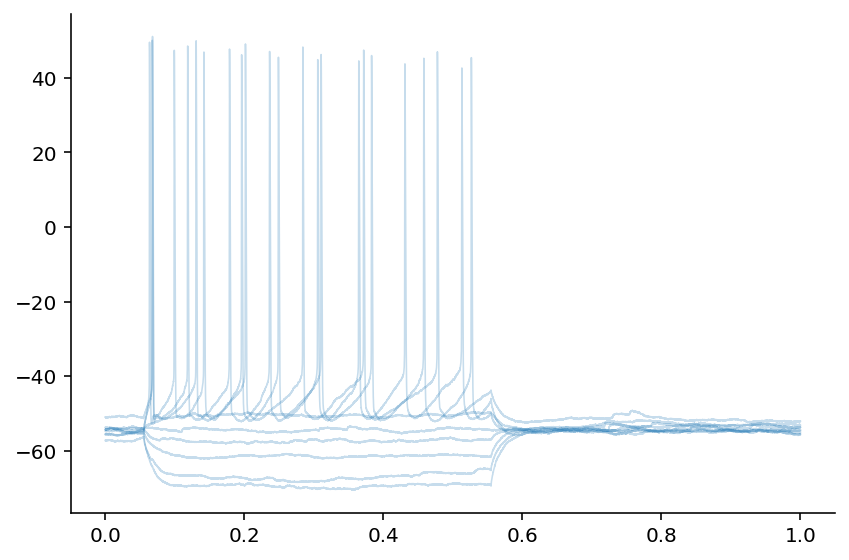

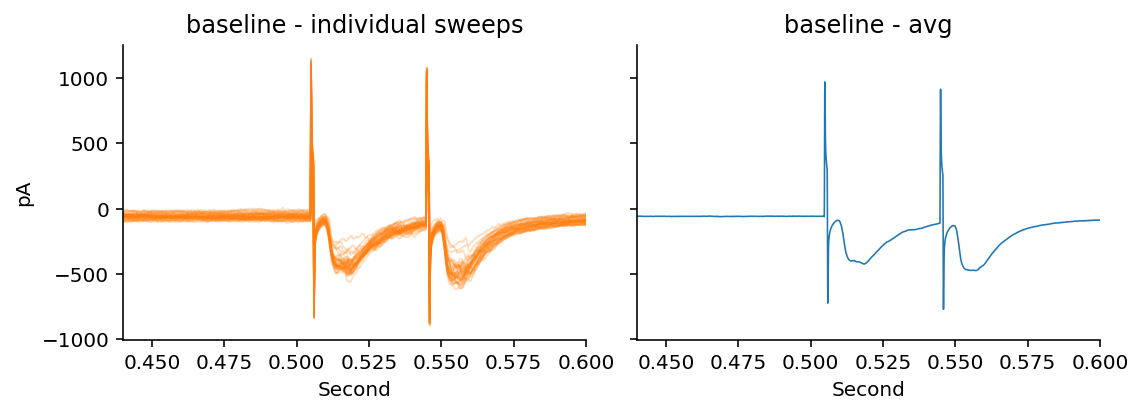

In [8]:
## Load file for plotting
## CC
filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s2cc.pxp'
traces = load_igor_pxp(filename)
if '221012s1cc' in filename:
    traces = [t*10 for t in traces] # gain wrong
plot_traces(traces)
sns.despine()
plt.tight_layout()

## VC
filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s2vc.pxp'

fig,axes = plt.subplots(ncols=2,figsize=[8,3],sharey=True,sharex=True)

traces = load_igor_pxp(filename)
plot_traces(np.array(traces[4:40]).mean(axis=0),ax=axes[1])
# plt.xlim([0.44,0.6])
# plt.title('baseline')
axes[0].set_ylabel('pA')
axes[0].set_xlabel('Second')
axes[1].set_xlabel('Second')
# filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp'
# traces = load_igor_pxp(filename)
plot_traces(traces[5:40],color='C1',ax=axes[0])
plt.xlim([0.44,0.6])
# plt.ylim([-2000,1200])
# plt.ylim([-800,250])

axes[0].set_title('baseline - individual sweeps')
axes[1].set_title('baseline - avg')

sns.despine()
plt.tight_layout()
plt.savefig('laura_s2_baseline.png',dpi=300,facecolor='w')

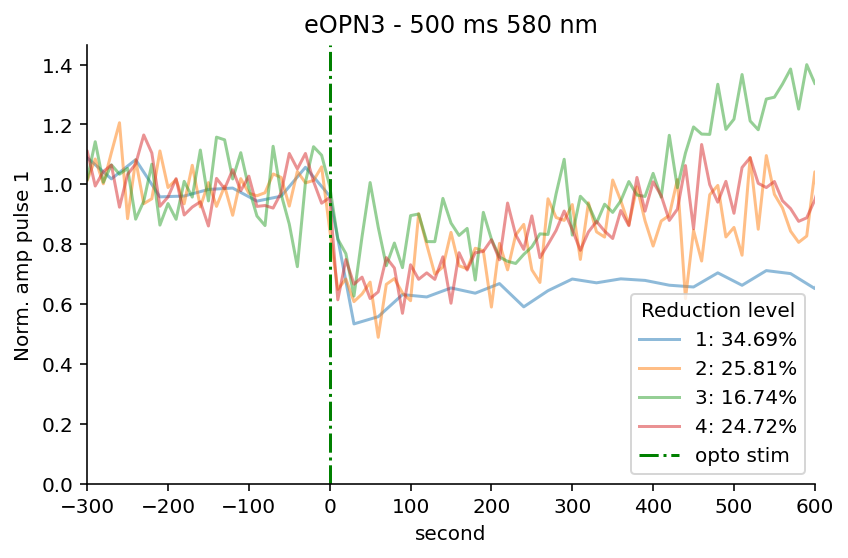

In [9]:
## Loop for all files
df_dict = {}
filename_list = ['/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp',
                 '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s2vc.pxp',
                 '/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s1vc.pxp',
                 '/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s2vc.pxp']

sweep_dict = {'221012s2vc':[20,51,141,10],
              '221012s1vc':[4,41,101,10],
              '221011s2vc':[28,68,160,10],
              '221011s1vc':[7,19,61,30]} 
for i, filename in enumerate(filename_list):
    name= filename.split('/')[-1].split('.')[0]
#     traces = load_igor_pxp(filename)
#     df = trace_to_df(traces)
    df = load_igor_to_df(filename)
    ## Generate new df for plotting & analysis
    start_sweep,opto_sweep,end_sweep,sample_rate = sweep_dict[name]
    df_ = cal_amp12_ppr(df,start_sweep,opto_sweep,end_sweep,sample_rate)
    df_dict[i+1] = df_

# for i in df_dict.keys():
#     df_dict[i][['amp1','amp2']].plot(title=i)
#     plt.axvline(0,ls=':')
#     plt.xlim(xmin=-300,xmax=600)

trace_norm = []
opto_reduced_concat = []
opto_mean_concat = []
plt.figure(figsize=[6,4])
for i in df_dict.keys():
    df_ = normalize_baseline(df_dict[i],amp='amp1')
    opto_mean,opto_reduced = opto_reduction(df_,amp='amp1')
    opto_reduced_concat.append(opto_reduced)
    opto_mean_concat.append(opto_mean)
#     df_[['amp1','amp2']].plot(title=i)
    plt.plot(df_[['amp1']],alpha=0.5,label=f'{i}: {round(opto_reduced*100,2)}%')
    trace_norm.append(df_.loc[-300:600]['amp1'].values)
    
# plt.axhline(1,ls=':',color='k',alpha=0.5)
#     plt.axhline(opto_mean,ls=':',color='C1')
plt.axvline(0,ls='-.',color='green',label='opto stim')
#     plt.text(x=500,y=0.25,s=f'Reduced: {round(opto_reduced*100,2)}%',ha='right',va='bottom')
plt.legend(loc=4,title='Reduction level')
plt.xlim(xmin=-300,xmax=600)
plt.ylim(ymin=0)
plt.xlabel('second')
plt.ylabel('Norm. amp pulse 1')
plt.title('eOPN3 - 500 ms 580 nm')
sns.despine()
plt.tight_layout()
plt.savefig('norm_traces.png',dpi=300,facecolor='w')
# opto_reduced_concat

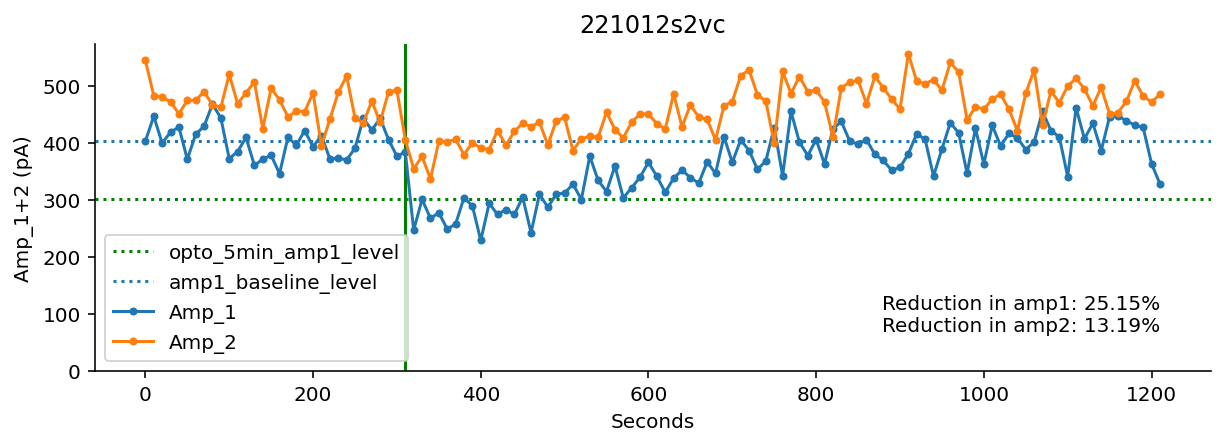

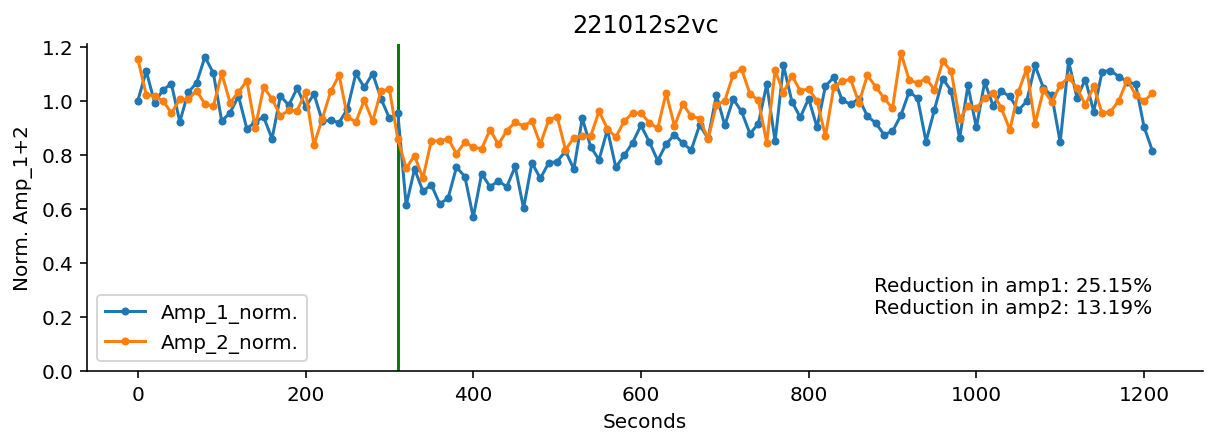

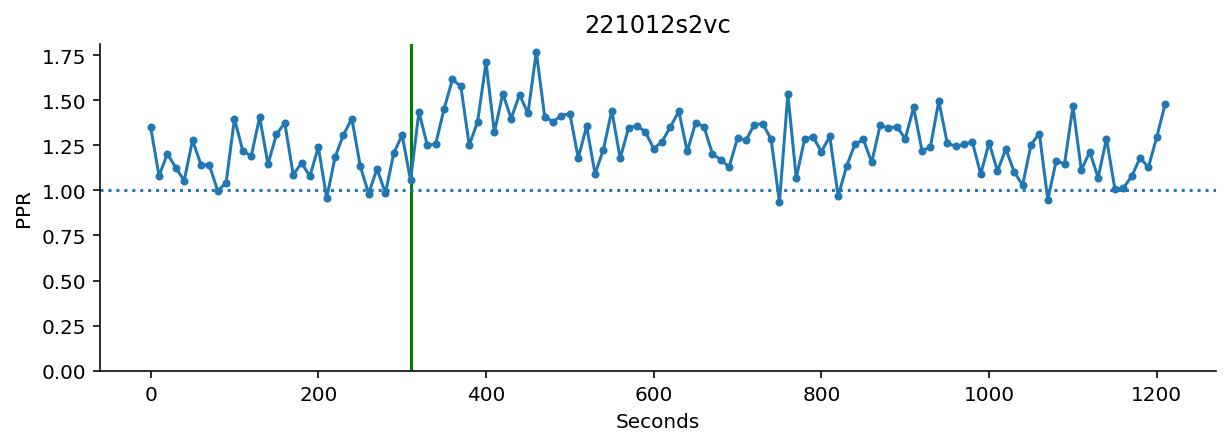

In [10]:
# Plot 1 file

df = trace_to_df(traces)

amp1_concat = []
amp2_concat = []
PPR_concat = []
figtitle = filename.split('/')[-1].split('.')[0]

# opto_sweep = 18-6 # slice 1
# opto_sweep = 67-27 # slice 2
# opto_sweep = 41-1-3 # 221012 slice 1
opto_sweep = 51-1-19 # 221012 slice 2


plt.figure(figsize=[10,3])    
plt.title(figtitle)
# for i in range(6,60): # for slice 1
# for i in range(27,159): # for slice 2
# for i in range(3,100): # for 221012 slice 1
for i in range(19,141): # for 221012 slice 2
    amp_1,amp_2,PPR = amps_2_pulse(df,i)    
    if len(amp2_concat)!=0:
#         print(i,amp_2,np.nanmean(amp2_concat))
        if amp_2 > np.nanmean(amp2_concat)*1.5:
            amp_2 = np.nan
            PPR = np.nan
    amp1_concat.append(amp_1)
    amp2_concat.append(amp_2)
    PPR_concat.append(PPR)
    

if '221011s1' in filename:
    t_scale = np.arange(len(amp1_concat))*30 # every 30 sec
    amp1_reduction = 100-round(np.nanmean(amp1_concat[opto_sweep:opto_sweep+5*2])/np.nanmean(amp1_concat[0:opto_sweep])*100,2)
    amp1_reduction = round(amp1_reduction,2)
    amp2_reduction = 100-round(np.nanmean(amp2_concat[opto_sweep:opto_sweep+5*2])/np.nanmean(amp2_concat[0:opto_sweep])*100,2)
    amp2_reduction = round(amp2_reduction,2)
    plt.axhline(np.mean(amp1_concat[opto_sweep:opto_sweep+5*2]),label='opto_5min_amp1_level',ls=':',color='green')

else:
    t_scale = np.arange(len(amp1_concat))*10 # every 10 sec
    amp1_reduction = 100-round(np.nanmean(amp1_concat[opto_sweep:opto_sweep+5*6])/np.nanmean(amp1_concat[0:opto_sweep])*100,2)
    amp1_reduction = round(amp1_reduction,2)
    amp2_reduction = 100-round(np.nanmean(amp2_concat[opto_sweep:opto_sweep+5*6])/np.nanmean(amp2_concat[0:opto_sweep])*100,2)
    amp2_reduction = round(amp2_reduction,2)
    plt.axhline(np.nanmean(amp1_concat[opto_sweep:opto_sweep+5*6]),label='opto_5min_amp1_level',ls=':',color='green')
plt.axhline(np.nanmean(amp1_concat[0:opto_sweep]),label='amp1_baseline_level',ls=':')
# plt.axhline(np.nanmean(amp2_concat[0:opto_sweep]),label='amp2_baseline_level',ls=':')
plt.axvline(t_scale[opto_sweep],color='green')
plt.text(x=max(t_scale),y=np.max(amp1_concat)*0.15,
         s=f'Reduction in amp1: {amp1_reduction}%\nReduction in amp2: {amp2_reduction}%',ha='right')
plt.plot(t_scale,amp1_concat,marker='.',label='Amp_1')
plt.plot(t_scale,amp2_concat,marker='.',label='Amp_2')
plt.legend(loc=3)
plt.xlabel('Seconds')
plt.ylabel('Amp_1+2 (pA)')
plt.ylim(ymin=0)
sns.despine()
    
# Plot normalization
plt.figure(figsize=[10,3])
plt.title(figtitle)
plt.axvline(t_scale[opto_sweep],color='green')
plt.text(x=max(t_scale),y=0.2,
         s=f'Reduction in amp1: {amp1_reduction}%\nReduction in amp2: {amp2_reduction}%',ha='right',va='bottom')
plt.plot(t_scale,amp1_concat/np.nanmean(amp1_concat[0:opto_sweep]),marker='.',label='Amp_1_norm.')
plt.plot(t_scale,amp2_concat/np.nanmean(amp2_concat[0:opto_sweep]),marker='.',label='Amp_2_norm.')
plt.legend(loc=3)
plt.xlabel('Seconds')
plt.ylabel('Norm. Amp_1+2')
plt.ylim(ymin=0)
sns.despine()

plt.figure(figsize=[10,3])
plt.title(figtitle)
plt.axvline(t_scale[opto_sweep],color='green')

plt.plot(t_scale,PPR_concat,marker='.')
plt.xlabel('Seconds')
plt.ylabel('PPR')
plt.ylim(ymin=0)
plt.axhline(y=1,ls=':')
sns.despine()

/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp
/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s2vc.pxp
/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s1vc.pxp
/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s2vc.pxp
['/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11003.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11005.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11006.abf']
['/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11003.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11005.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11006.abf']
['/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12002.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12004.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12005.abf']
['/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12002.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12004.abf', '/Users/hunglo/Desktop/eOPN3_slice/Luka

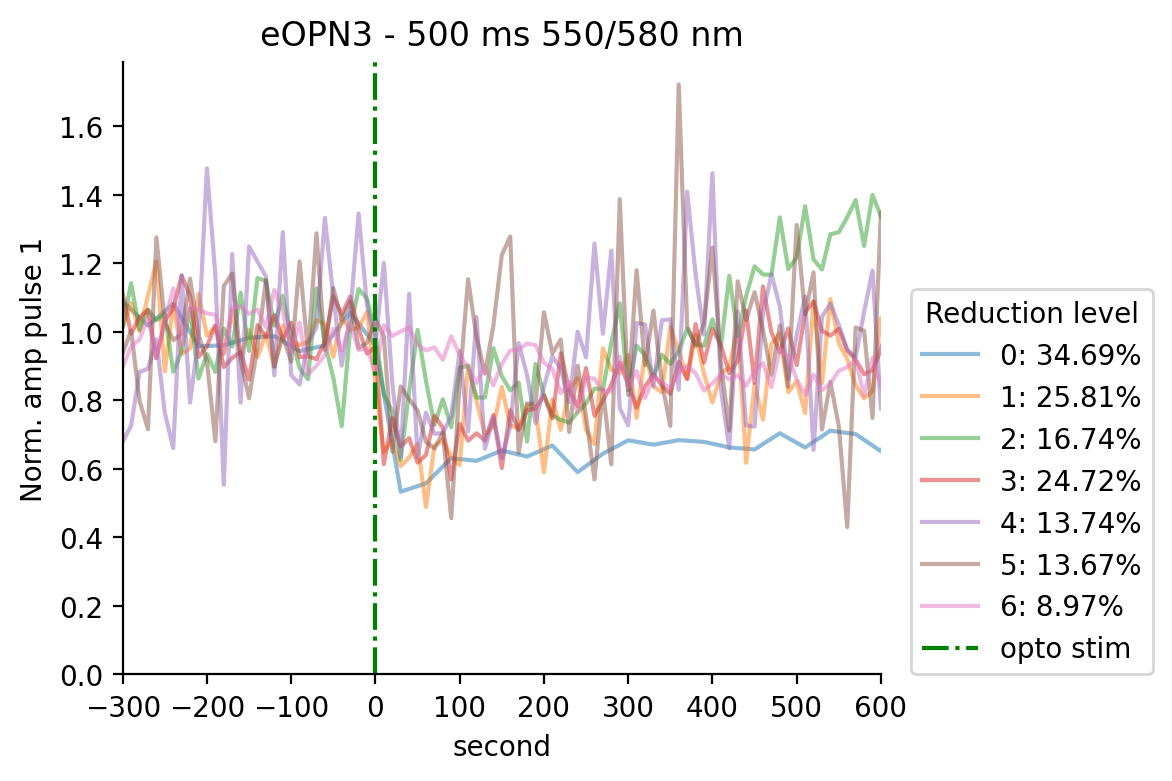

In [28]:
## Laura + Lukas's
import matplotlib as mpl
mpl.rc_file_defaults()

df_dict = {}
filename_list_laura = ['/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp',
                 '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s2vc.pxp',
                 '/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s1vc.pxp',
                 '/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s2vc.pxp']
filename_list_lukas = [['/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11003.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11005.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11006.abf'],
             ['/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12002.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12004.abf', 
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12005.abf'], 
             ['/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12014.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12016.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12017.abf']]
filename_list = filename_list_laura + filename_list_lukas

sweep_dict = {'221012s2vc':[20,51,141,10],
              '221012s1vc':[4,41,101,10],
              '221011s2vc':[28,68,160,10],
              '221011s1vc':[7,19,61,30]} 

trace_norm = []
opto_reduced_concat = []
opto_mean_concat = []

plt.figure(figsize=[6,4])
k = 1
# j = 5
df_dict = {}
for i, filename in enumerate(filename_list):
    print(filename)
    if 'pxp' in filename:
        
        name= filename.split('/')[-1].split('.')[0]
        df = load_igor_to_df(filename)
        ## Generate new df for plotting & analysis
        start_sweep,opto_sweep,end_sweep,sample_rate = sweep_dict[name]
        df_ = cal_amp12_ppr(df,start_sweep,opto_sweep,end_sweep,sample_rate)
        df_dict[i] = df_

    else:
        print(filename)
        start_sweep = 10
        sweep_dict_abf = {}
#         df_dict = {}
        df_list = []
        df = []
        df_merge = []
        for idx, file in enumerate(filename):
            df = load_abf_to_df(file)
            if idx ==0:
                opto_sweep = df.shape[1] # get the finish 
            df_list.append(df)
        df_merge = pd.concat(df_list,axis=1,ignore_index=True)
        end_sweep = df_merge.shape[1]

        ## save sweep data to sweep dict for abf files
        sample_rate = 10
        ## Now extract amp
        df_ = cal_amp12_ppr_abf(df_merge,start_sweep,opto_sweep,end_sweep,sample_rate)
        df_dict[i]=df_
        
for i_ in df_dict.keys():
    df_ = normalize_baseline(df_dict[i_],amp='amp1')
    opto_mean,opto_reduced = opto_reduction(df_,amp='amp1')
    opto_reduced_concat.append(opto_reduced)
    opto_mean_concat.append(opto_mean)
    plt.plot(df_[['amp1']],alpha=0.5,label=f'{i_}: {round(opto_reduced*100,2)}%')
    trace_norm.append(df_.loc[-300:600]['amp1'].values)

opto_mean_amp1 = opto_mean_concat.copy()
plt.axvline(0,ls='-.',color='green',label='opto stim')
plt.legend(loc=(1.04,0),title='Reduction level')
# plt.legend(loc=(1.04, 0))
plt.xlim(xmin=-300,xmax=600)
plt.ylim(ymin=0)
plt.xlabel('second')
plt.ylabel('Norm. amp pulse 1')
plt.title('eOPN3 - 500 ms 550/580 nm')
sns.despine()
plt.tight_layout()
plt.savefig('norm_traces_all_pulse1.png',dpi=300,facecolor='w')


/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp
/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s2vc.pxp
/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s1vc.pxp
/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s2vc.pxp
['/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11003.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11005.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11006.abf']
['/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11003.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11005.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11006.abf']
['/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12002.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12004.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12005.abf']
['/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12002.abf', '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12004.abf', '/Users/hunglo/Desktop/eOPN3_slice/Luka

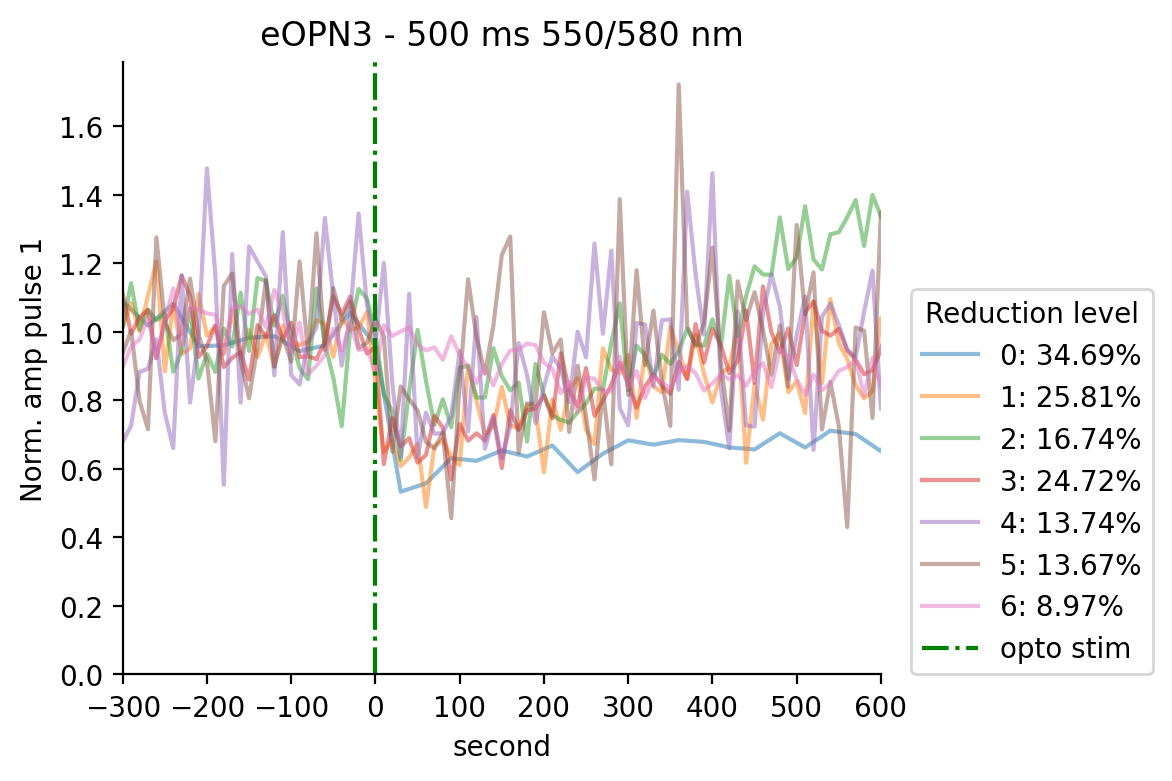

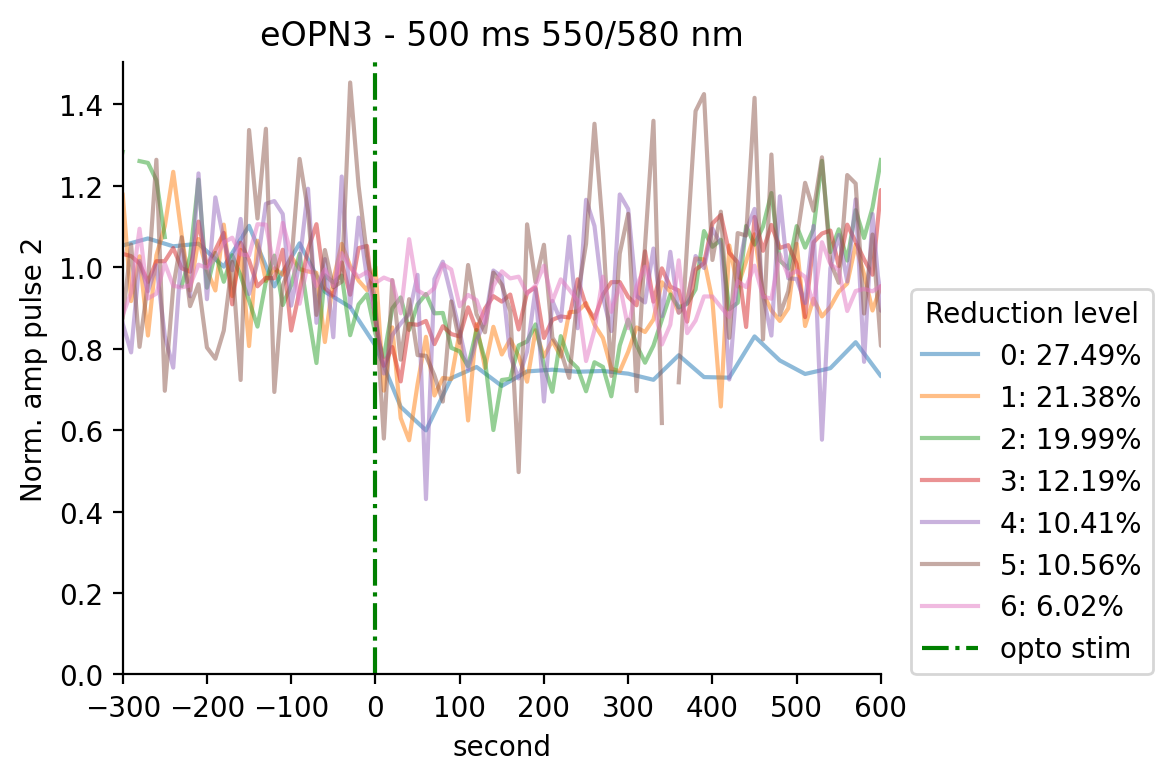

In [31]:
## Laura + Lukas's
import matplotlib as mpl
mpl.rc_file_defaults()

df_dict = {}
filename_list_laura = ['/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp',
                 '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s2vc.pxp',
                 '/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s1vc.pxp',
                 '/Users/hunglo/Desktop/eOPN3_slice/Laura/221012s2vc.pxp']
filename_list_lukas = [['/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11003.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11005.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/11.10.2022/22o11006.abf'],
             ['/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12002.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12004.abf', 
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12005.abf'], 
             ['/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12014.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12016.abf',
              '/Users/hunglo/Desktop/eOPN3_slice/Lukas/12.10.2022/22o12017.abf']]
filename_list = filename_list_laura + filename_list_lukas

sweep_dict = {'221012s2vc':[20,51,141,10],
              '221012s1vc':[4,41,101,10],
              '221011s2vc':[28,68,160,10],
              '221011s1vc':[7,19,61,30]} 

trace_norm = []
opto_reduced_concat = []
opto_mean_concat = []
df_dict = {} # this dict stores all the processed data with amp1, amp2, and PPR

for i, filename in enumerate(filename_list):
    print(filename)
    if 'pxp' in filename:
        
        name= filename.split('/')[-1].split('.')[0]
        df = load_igor_to_df(filename)
        ## Generate new df for plotting & analysis
        start_sweep,opto_sweep,end_sweep,sample_rate = sweep_dict[name]
        df_ = cal_amp12_ppr(df,start_sweep,opto_sweep,end_sweep,sample_rate)
        df_dict[i] = df_

    else:
        print(filename)
        start_sweep = 10
        sweep_dict_abf = {}
#         df_dict = {}
        df_list = []
        df = []
        df_merge = []
        for idx, file in enumerate(filename):
            df = load_abf_to_df(file)
            if idx ==0:
                opto_sweep = df.shape[1] # get the finish 
            df_list.append(df)
        df_merge = pd.concat(df_list,axis=1,ignore_index=True)
        end_sweep = df_merge.shape[1]

        ## save sweep data to sweep dict for abf files
        sample_rate = 10
        ## Now extract amp
        df_ = cal_amp12_ppr_abf(df_merge,start_sweep,opto_sweep,end_sweep,sample_rate)
        df_dict[i]=df_

## Plotting pulse 1
plt.figure(figsize=[6,4])
for i_ in df_dict.keys():
    df_ = normalize_baseline(df_dict[i_],amp='amp1')
    opto_mean,opto_reduced = opto_reduction(df_,amp='amp1')
    opto_reduced_concat.append(opto_reduced)
    opto_mean_concat.append(opto_mean)
    plt.plot(df_[['amp1']],alpha=0.5,label=f'{i_}: {round(opto_reduced*100,2)}%')
    trace_norm.append(df_.loc[-300:600]['amp1'].values)

opto_mean_amp1 = opto_mean_concat.copy()
plt.axvline(0,ls='-.',color='green',label='opto stim')
plt.legend(loc=(1.04,0),title='Reduction level')
# plt.legend(loc=(1.04, 0))
plt.xlim(xmin=-300,xmax=600)
plt.ylim(ymin=0)
plt.xlabel('second')
plt.ylabel('Norm. amp pulse 1')
plt.title('eOPN3 - 500 ms 550/580 nm')
sns.despine()
plt.tight_layout()
plt.savefig('norm_traces_all_pulse1.png',dpi=300,facecolor='w')

## Plotting pulse 2
plt.figure(figsize=[6,4])
for i_ in df_dict.keys():
    df_ = normalize_baseline(df_dict[i_],amp='amp2')
    opto_mean,opto_reduced = opto_reduction(df_,amp='amp2')
    opto_reduced_concat.append(opto_reduced)
    opto_mean_concat.append(opto_mean)
    plt.plot(df_[['amp2']],alpha=0.5,label=f'{i_}: {round(opto_reduced*100,2)}%')
    trace_norm.append(df_.loc[-300:600]['amp2'].values)

opto_mean_amp2 = opto_mean_concat.copy()
plt.axvline(0,ls='-.',color='green',label='opto stim')
plt.legend(loc=(1.04,0),title='Reduction level')
# plt.legend(loc=(1.04, 0))
plt.xlim(xmin=-300,xmax=600)
plt.ylim(ymin=0)
plt.xlabel('second')
plt.ylabel('Norm. amp pulse 2')
plt.title('eOPN3 - 500 ms 550/580 nm')
sns.despine()
plt.tight_layout()
plt.savefig('norm_traces_all_pulse2.png',dpi=300,facecolor='w')


SpearmanrResult(correlation=0.9285714285714288, pvalue=0.0025194724037946874)
(0.8459593621413062, 0.016433451177632546)


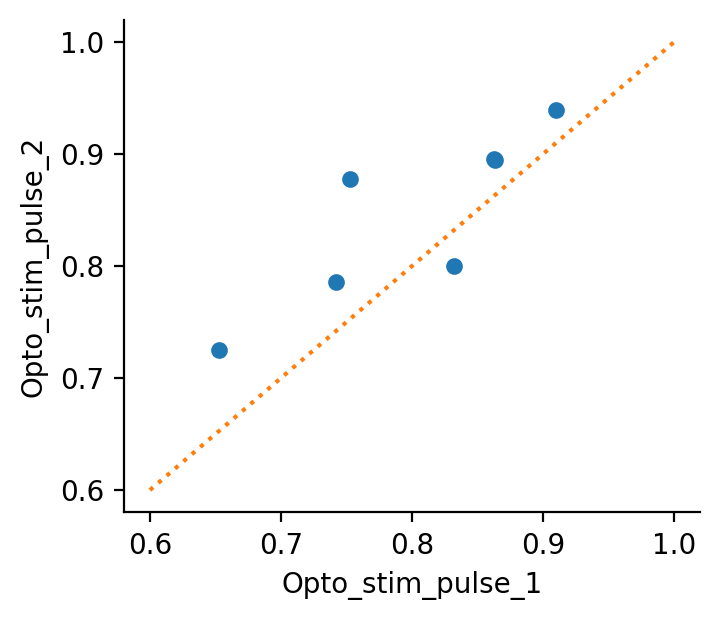

In [19]:
plt.figure(figsize=[3.5,3])
plt.plot(opto_mean_amp1,opto_mean_amp2,ls='',marker='.',markersize=10)
plt.plot([0.6,1],[0.6,1],ls=':',)
plt.tight_layout()
plt.ylabel('Opto_stim_pulse_2')
plt.xlabel('Opto_stim_pulse_1')
sns.despine()

from scipy import stats
pprint.pprint(stats.spearmanr(opto_mean_amp1,opto_mean_amp2))
pprint.pprint(stats.pearsonr(opto_mean_amp1,opto_mean_amp2))


In [20]:
df_opto = pd.DataFrame([np.ones(len(opto_mean_concat)),opto_mean_concat]).T
df_opto.rename(columns={0: 'baseline', 1: 'opto_stimu'}, inplace=True)
df_opto = df_opto.melt(var_name='condition',value_name='norm. EPSC amp')
df_opto


,condition,norm. EPSC amp
0,baseline,1.000000
1,baseline,1.000000
2,baseline,1.000000
3,baseline,1.000000
4,baseline,1.000000
5,baseline,1.000000
6,baseline,1.000000
7,opto_stimu,0.653091
8,opto_stimu,0.741887
9,opto_stimu,0.832568


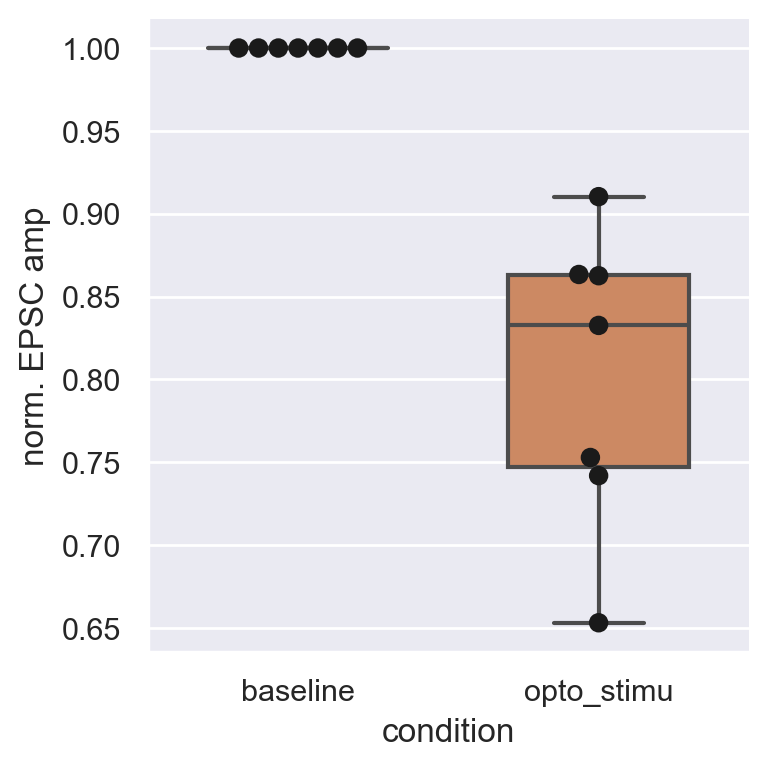

In [22]:
sns.set()
plt.figure(figsize=[4,4])
sns.swarmplot(data=df_opto,x='condition',y='norm. EPSC amp',color='k',s=7)
sns.boxplot(data=df_opto,x='condition',y='norm. EPSC amp',width=0.6)
sns.despine()
# plt.ylim(ymin=0.5)
plt.tight_layout()

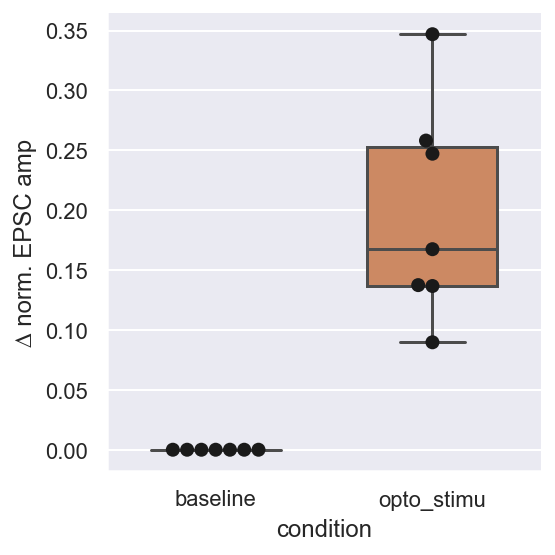

In [292]:
df_opto_redu = pd.DataFrame([np.zeros(len(opto_reduced_concat)),opto_reduced_concat]).T
df_opto_redu.rename(columns={0: 'baseline', 1: 'opto_stimu'}, inplace=True)
df_opto_redu = df_opto_redu.melt(var_name='condition',value_name='∆ norm. EPSC amp')
df_opto_redu

sns.set()
plt.figure(figsize=[4,4])
sns.swarmplot(data=df_opto_redu,x='condition',y='∆ norm. EPSC amp',color='k',s=7)
sns.boxplot(data=df_opto_redu,x='condition',y='∆ norm. EPSC amp',width=0.6)
sns.despine()
# plt.ylim(ymin=0.5)
plt.tight_layout()

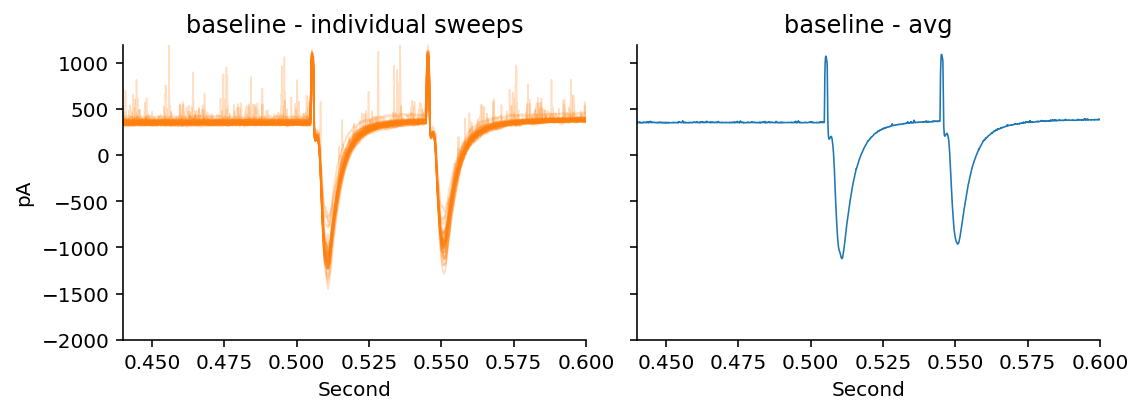

In [263]:
filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp'

fig,axes = plt.subplots(ncols=2,figsize=[8,3],sharey=True,sharex=True)

traces = load_igor_pxp(filename)
plot_traces(np.array(traces[27:66]).mean(axis=0),ax=axes[1])
# plt.xlim([0.44,0.6])
# plt.title('baseline')
axes[0].set_ylabel('pA')
axes[0].set_xlabel('Second')
axes[1].set_xlabel('Second')
# filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp'
# traces = load_igor_pxp(filename)
plot_traces(traces[27:66],color='C1',ax=axes[0])
plt.xlim([0.44,0.6])
plt.ylim([-2000,1200])
# plt.ylim([-800,250])

axes[0].set_title('baseline - individual sweeps')
axes[1].set_title('baseline - avg')

sns.despine()
plt.tight_layout()
plt.savefig('laura_s2_baseline.png',dpi=300,facecolor='w')

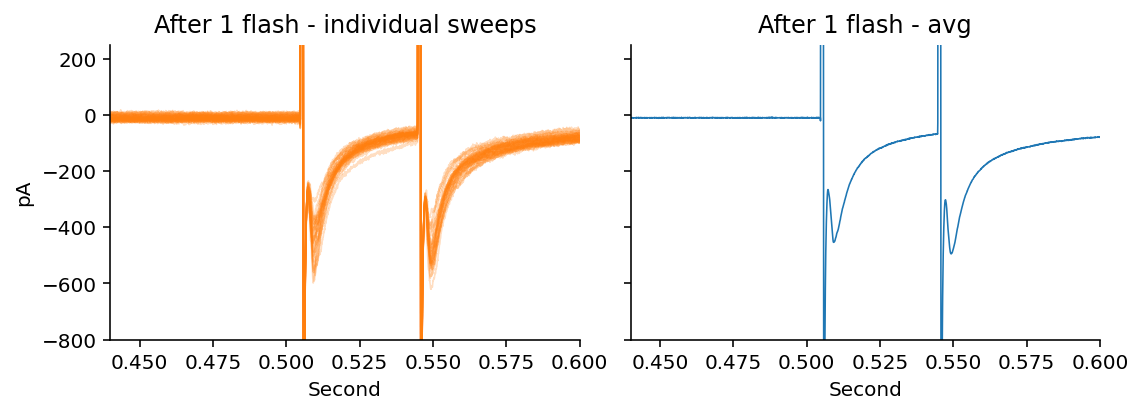

In [101]:
fig,axes = plt.subplots(ncols=2,figsize=[8,3],sharey=True,sharex=True)

traces = load_igor_pxp(filename)
plot_traces(np.array(traces[68:98]).mean(axis=0),ax=axes[1])
# plt.xlim([0.44,0.6])
# plt.title('baseline')
axes[0].set_ylabel('pA')
axes[0].set_xlabel('Second')
axes[1].set_xlabel('Second')
# filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp'
# traces = load_igor_pxp(filename)
plot_traces(traces[68:98],color='C1',ax=axes[0])
plt.xlim([0.44,0.6])
# plt.ylim([-2000,1200])
plt.ylim([-800,250])
axes[0].set_title('After 1 flash - individual sweeps')
axes[1].set_title('After 1 flash - avg')

sns.despine()
plt.tight_layout()

plt.savefig('laura_s2_stim_5min.png',dpi=300,facecolor='w')

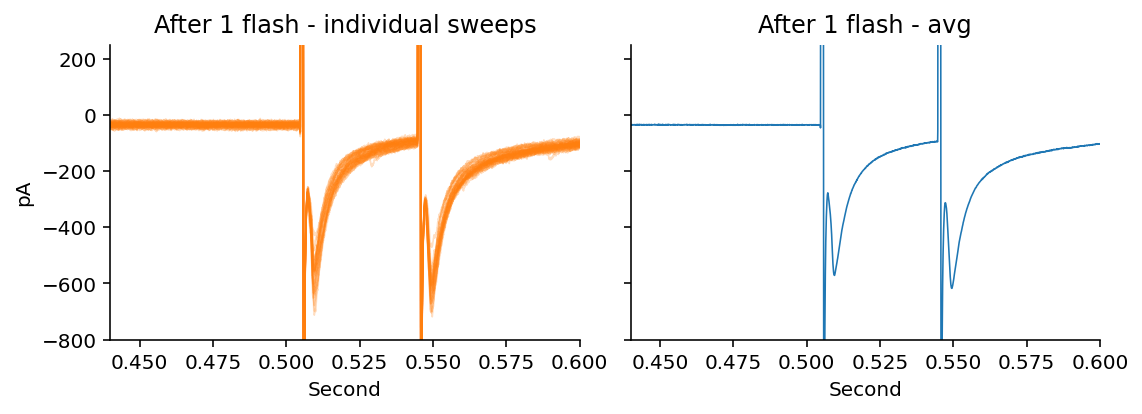

In [102]:
fig,axes = plt.subplots(ncols=2,figsize=[8,3],sharey=True,sharex=True)

traces = load_igor_pxp(filename)
plot_traces(np.array(traces[98:128]).mean(axis=0),ax=axes[1])
# plt.xlim([0.44,0.6])
# plt.title('baseline')
axes[0].set_ylabel('pA')
axes[0].set_xlabel('Second')
axes[1].set_xlabel('Second')
# filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp'
# traces = load_igor_pxp(filename)
plot_traces(traces[98:128],color='C1',ax=axes[0])
plt.xlim([0.44,0.6])
# plt.ylim([-2000,1200])
plt.ylim([-800,250])
axes[0].set_title('After 1 flash - individual sweeps')
axes[1].set_title('After 1 flash - avg')

sns.despine()
plt.tight_layout()

plt.savefig('laura_s2_stim_5-10min.png',dpi=300,facecolor='w')

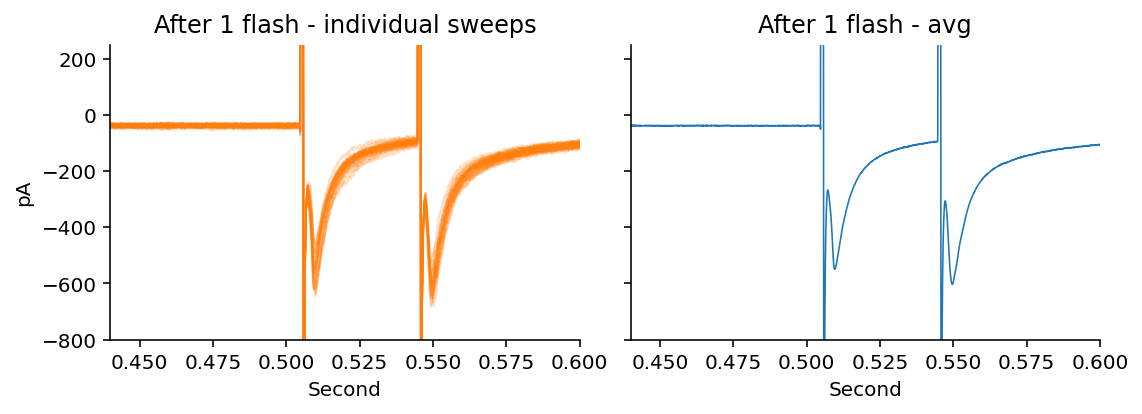

In [103]:
fig,axes = plt.subplots(ncols=2,figsize=[8,3],sharey=True,sharex=True)

traces = load_igor_pxp(filename)
plot_traces(np.array(traces[128:158]).mean(axis=0),ax=axes[1])
# plt.xlim([0.44,0.6])
# plt.title('baseline')
axes[0].set_ylabel('pA')
axes[0].set_xlabel('Second')
axes[1].set_xlabel('Second')
# filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp'
# traces = load_igor_pxp(filename)
plot_traces(traces[128:158],color='C1',ax=axes[0])
plt.xlim([0.44,0.6])
# plt.ylim([-2000,1200])
plt.ylim([-800,250])
axes[0].set_title('After 1 flash - individual sweeps')
axes[1].set_title('After 1 flash - avg')

sns.despine()
plt.tight_layout()

plt.savefig('laura_s2_stim_10-15min.png',dpi=300,facecolor='w')

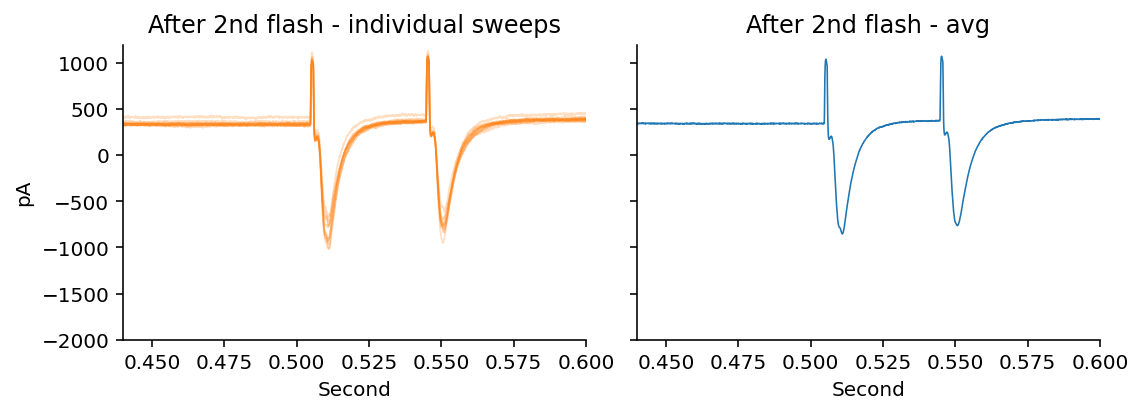

In [86]:
fig,axes = plt.subplots(ncols=2,figsize=[8,3],sharey=True,sharex=True)

traces = load_igor_pxp(filename)
plot_traces(np.array(traces[61:72]).mean(axis=0),ax=axes[1])
# plt.xlim([0.44,0.6])
# plt.title('baseline')
axes[0].set_ylabel('pA')
axes[0].set_xlabel('Second')
axes[1].set_xlabel('Second')
# filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp'
# traces = load_igor_pxp(filename)
plot_traces(traces[61:72],color='C1',ax=axes[0])
plt.xlim([0.44,0.6])
plt.ylim([-2000,1200])
axes[0].set_title('After 2nd flash - individual sweeps')
axes[1].set_title('After 2nd flash - avg')

sns.despine()
plt.tight_layout()

plt.savefig('laura_s1_stim_2nd_5min.png',dpi=300,facecolor='w')

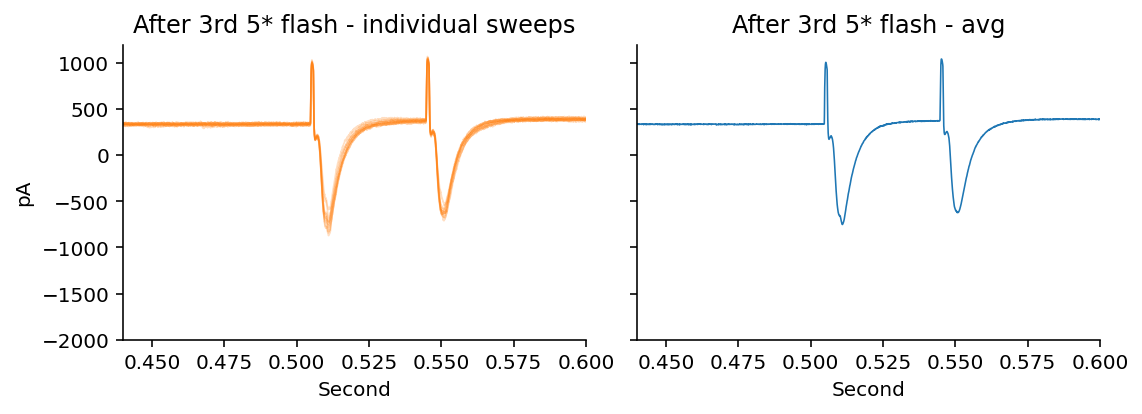

In [92]:
fig,axes = plt.subplots(ncols=2,figsize=[8,3],sharey=True,sharex=True)

traces = load_igor_pxp(filename)
plot_traces(np.array(traces[78:88]).mean(axis=0),ax=axes[1])
# plt.xlim([0.44,0.6])
# plt.title('baseline')
axes[0].set_ylabel('pA')
axes[0].set_xlabel('Second')
axes[1].set_xlabel('Second')
# filename = '/Users/hunglo/Desktop/eOPN3_slice/Laura/221011s1vc.pxp'
# traces = load_igor_pxp(filename)
plot_traces(traces[78:88],color='C1',ax=axes[0])
plt.xlim([0.44,0.6])
plt.ylim([-2000,1200])
axes[0].set_title('After 3rd 5* flash - individual sweeps')
axes[1].set_title('After 3rd 5* flash - avg')

sns.despine()
plt.tight_layout()

plt.savefig('laura_s1_stim_3rd_5min.png',dpi=300,facecolor='w')